In [22]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.signal import butter, filtfilt, hilbert, find_peaks
from scipy.fft import fft, fftfreq

# --- LOAD AUDIO ---
filename = 'audio_files/guitar-pluck-non-vibrato_1bpm.wav'  # Replace with your file
y, fs = librosa.load(filename, sr=None)
t = np.arange(len(y)) / fs


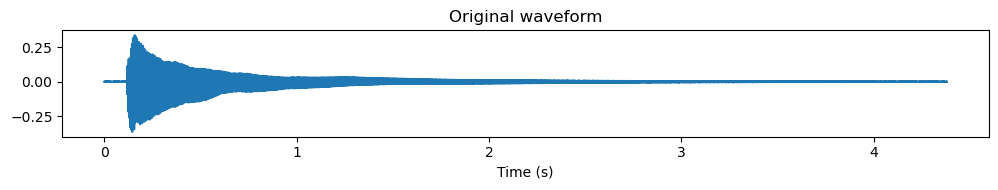

In [3]:
# --- PLOT WAVEFORM ---
plt.figure(figsize=(10, 2))
plt.plot(t, y)
plt.title("Original waveform")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()


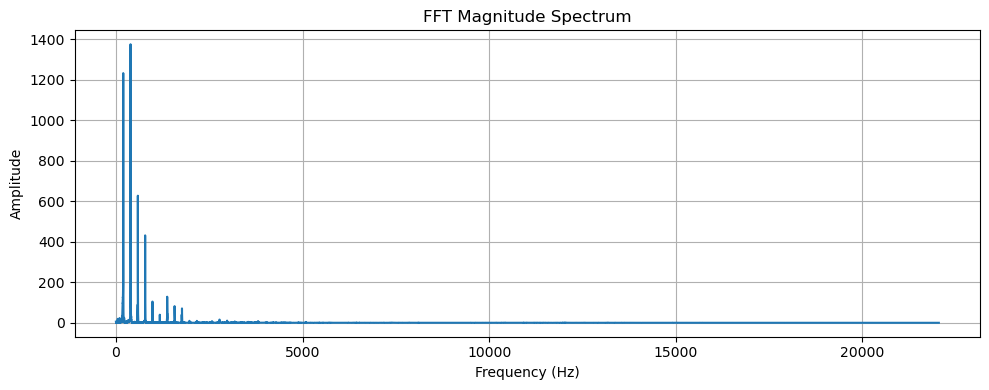

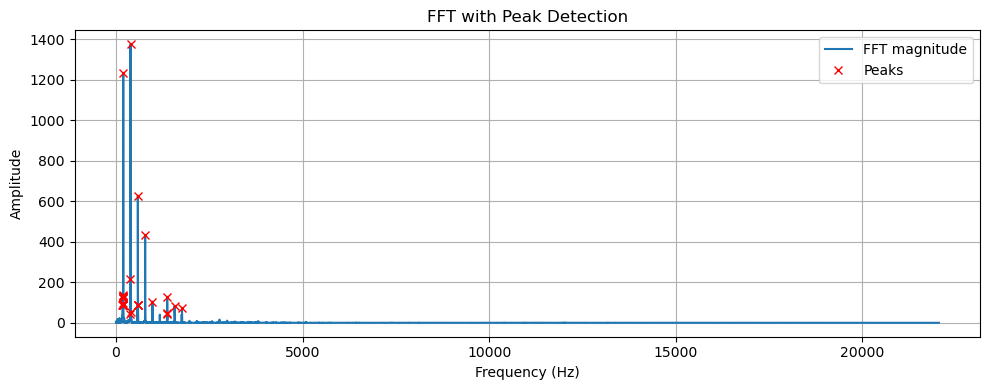

Peak frequencies (Hz): [ 176.04744843  176.73245796  177.18913098  177.64580399  179.24415956
  184.26756275  184.72423577  185.86591832  186.32259133  187.23593737
  188.37761992  189.74763897  196.36939773  383.6053351   389.77042084
  391.36877641  401.4155828   582.48643443  584.3131265   584.99813603
  587.28150112  783.19422583  979.33528705 1370.93239997 1371.845746
 1373.90077458 1571.41185486 1770.06461768]


In [24]:
# Compute FFT
n = len(y)
yf = fft(y)
xf = fftfreq(n, 1/fs)

# Plot magnitude spectrum
plt.figure(figsize=(10, 4))
plt.plot(xf[:n//2], np.abs(yf[:n//2]))
plt.title("FFT Magnitude Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

magnitude = np.abs(yf[:n//2])
frequencies = xf[:n//2]

# Find peaks above a threshold (e.g. 10% of max)
peaks, _ = find_peaks(magnitude, height=0.03 * np.max(magnitude))

# Get corresponding frequencies and magnitudes
peak_freqs = frequencies[peaks]
peak_mags = magnitude[peaks]

# Plot with peaks marked
plt.figure(figsize=(10, 4))
plt.plot(frequencies, magnitude, label="FFT magnitude")
plt.plot(peak_freqs, peak_mags, "x", label="Peaks", color='red')
plt.title("FFT with Peak Detection")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print peak frequencies
print("Peak frequencies (Hz):", peak_freqs)

In [4]:

# --- FUNDAMENTAL FREQUENCY ESTIMATION (ROUGH) ---
f0 = librosa.yin(y, fmin=80, fmax=1000, sr=fs)
f0_est = np.median(f0[np.isfinite(f0)])  # Use median to avoid outliers
print(f"Estimated f0: {f0_est:.2f} Hz")


Estimated f0: 391.24 Hz


In [11]:

# --- HARMONIC FREQUENCIES ---
num_harmonics = 20
harmonics = [f0_est * (i + 1) for i in range(num_harmonics)]


In [12]:

# --- BANDPASS FILTER FUNCTION ---
def bandpass_filter(signal, fs, f_center, bandwidth=30):
    nyq = fs / 2
    low = (f_center - bandwidth / 2) / nyq
    high = (f_center + bandwidth / 2) / nyq
    b, a = butter(N=4, Wn=[low, high], btype='band')
    return filtfilt(b, a, signal)


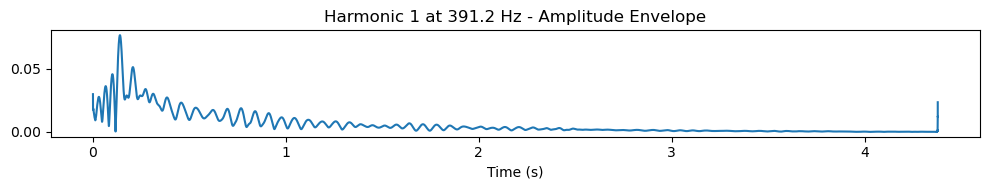

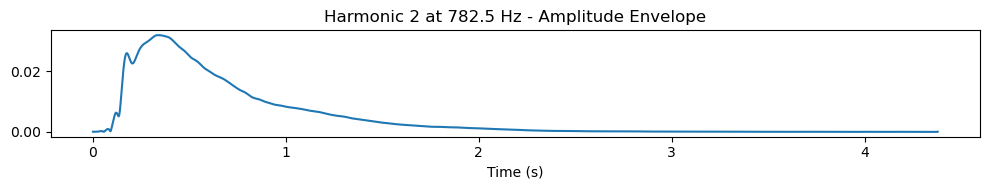

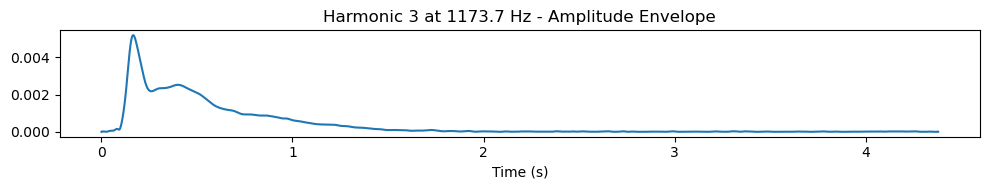

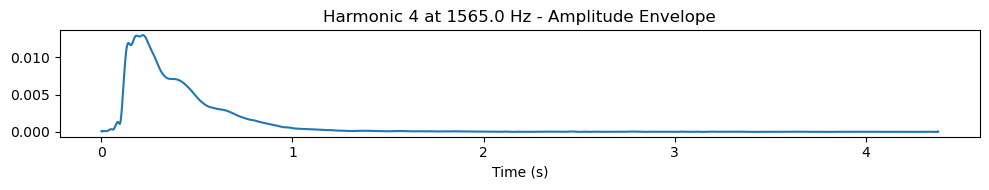

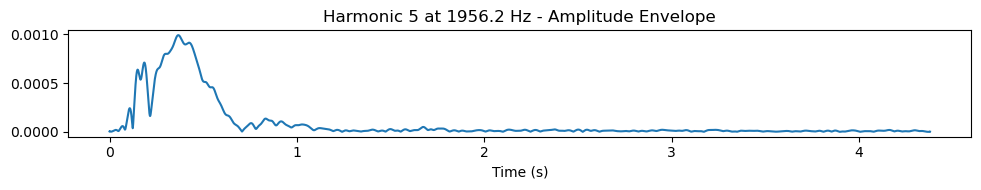

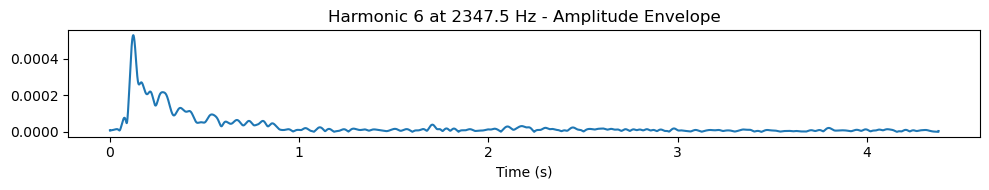

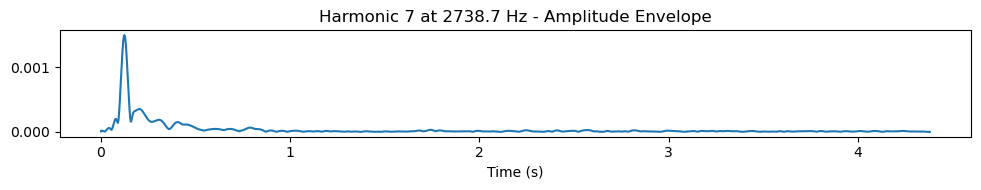

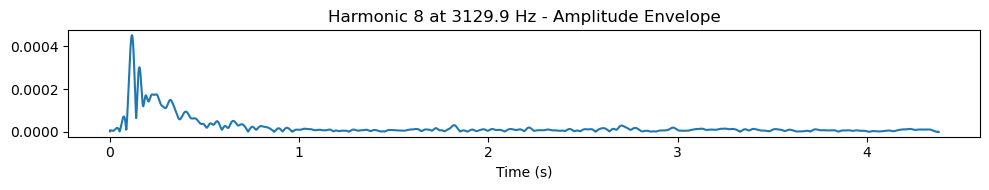

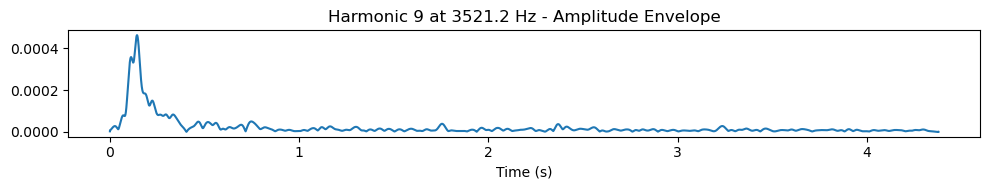

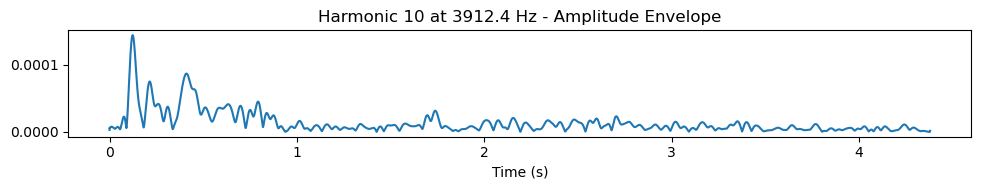

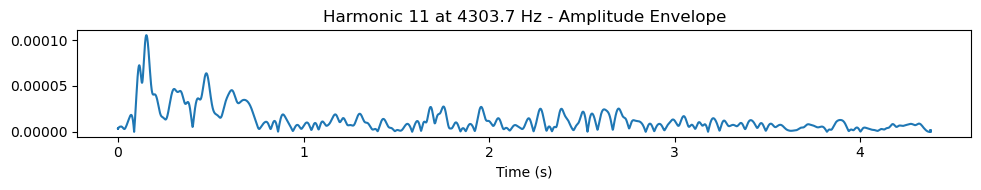

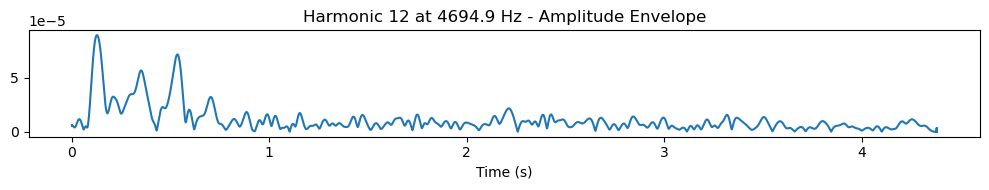

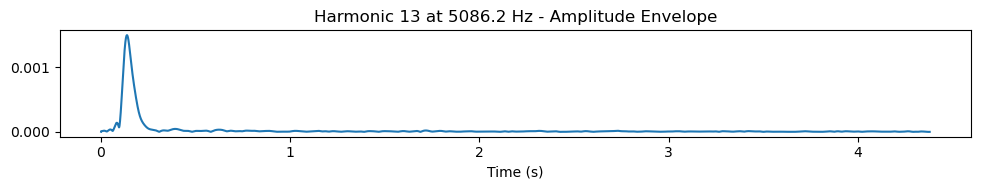

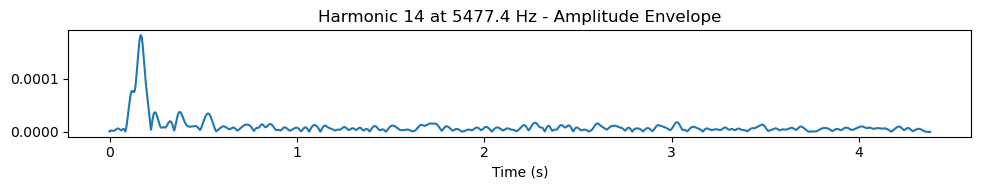

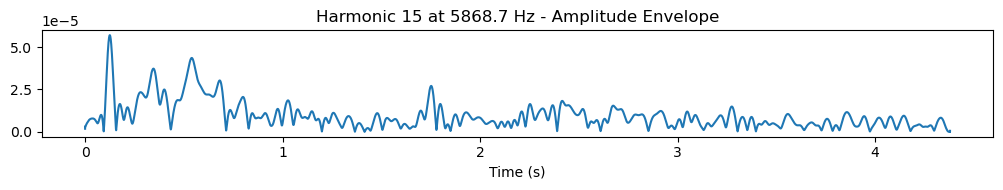

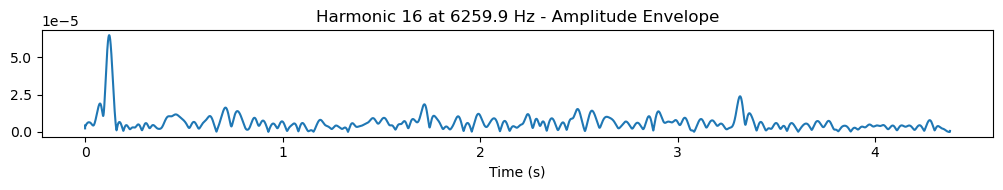

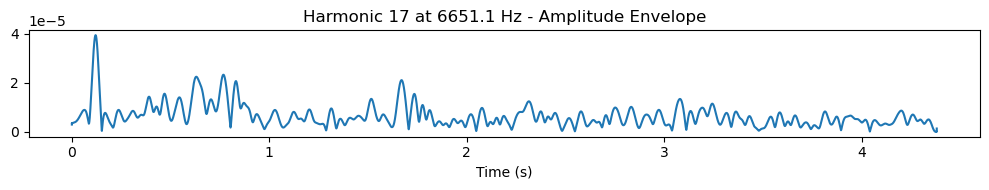

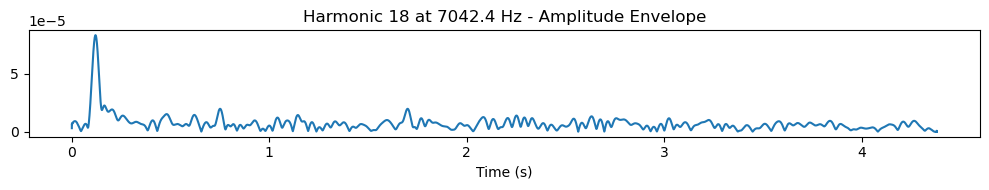

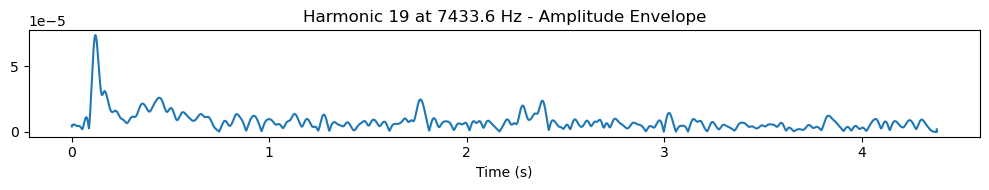

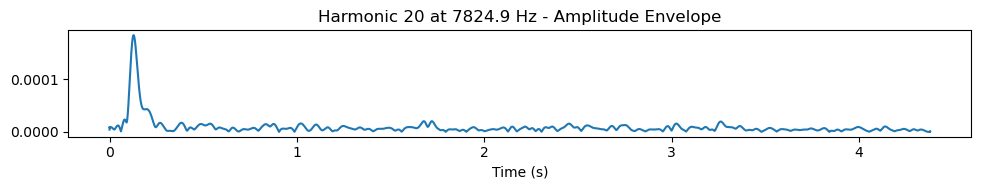

In [13]:

# --- HILBERT ANALYSIS + PLOT ---
envelopes = []
powers = []
recon = np.zeros_like(y)

for i, f in enumerate(harmonics):
    filtered = bandpass_filter(y, fs, f)
    analytic = hilbert(filtered)
    envelope = np.abs(analytic)
    envelopes.append(envelope)
    powers.append(envelope**2)
    recon += np.real(analytic)

    plt.figure(figsize=(10, 2))
    plt.plot(t, envelope)
    plt.title(f"Harmonic {i+1} at {f:.1f} Hz - Amplitude Envelope")
    plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.show()


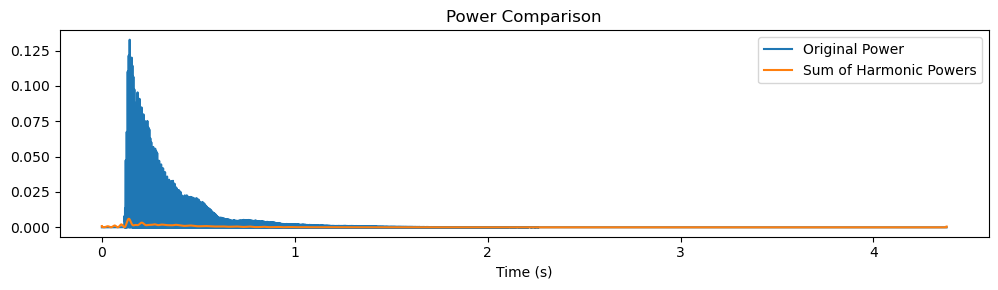

In [14]:

# --- POWER ANALYSIS ---
power_orig = y**2
power_sum = np.sum(powers, axis=0)

plt.figure(figsize=(10, 3))
plt.plot(t, power_orig, label='Original Power')
plt.plot(t, power_sum, label='Sum of Harmonic Powers')
plt.legend()
plt.title("Power Comparison")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()


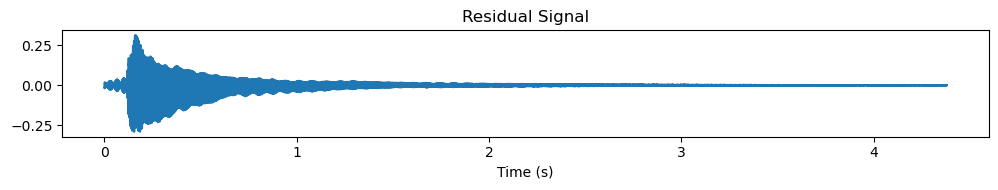

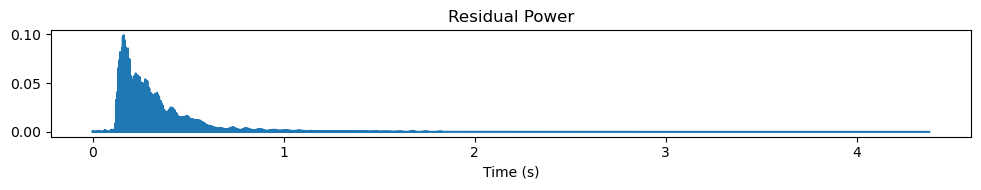

In [15]:

# --- RESIDUAL ANALYSIS ---
residual = y - recon
residual_power = residual**2

plt.figure(figsize=(10, 2))
plt.plot(t, residual)
plt.title("Residual Signal")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(t, residual_power)
plt.title("Residual Power")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()